# Predict using minimal data to show true demand

prepare a model that will use only arrival rates and aspirational targes for ED

Inputs
- A series of times in the day at which we want to make these predictions is set 
- A series of dates on which we want to make these predictions
- A time window after the prediction time, within which we are interested in predicting a number of patients (eg 8 hours)

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))


model_file_path = USER_ROOT / 'patientflow' / 'trained-models'
# model_file_path.mkdir(parents=True, exist_ok=True)
data_path = USER_ROOT / 'patientflow' / 'data-raw'
media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'
# media_file_path.mkdir(parents=True, exist_ok=True)

## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [33]:
uclh = False

In [34]:
from load_config import load_config_file

if uclh:
    config_path = Path(USER_ROOT / 'patientflow' / 'config-uclh.yaml')
else:
    config_path = Path(USER_ROOT / 'patientflow' / 'config.yaml')

params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]

x1, y1, x2, y2 = params[5:9]


## Load data

In [35]:
import pandas as pd
from load_data_utils import set_file_locations

if uclh:

    visits_path, visits_csv_path, yta_path, yta_csv_path = set_file_locations(uclh, data_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_file_locations(uclh, data_path)

yta = pd.read_csv(yta_csv_path)



In [36]:
yta.head()

,training_validation_test,arrival_datetime,sex,specialty,is_child
0,train,2031-04-24 19:21:00+00:00,M,haem/onc,False
1,train,2031-04-25 12:42:00+00:00,F,medical,False
2,train,2031-03-20 19:54:00+00:00,F,haem/onc,False
3,train,2031-03-04 22:03:00+00:00,F,haem/onc,False
4,train,2031-03-01 11:10:44+00:00,M,surgical,False


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. 

In [37]:
yta.training_validation_test.value_counts()

training_validation_test
train    7730
test     3701
valid    1244
Name: count, dtype: int64

In [38]:
train_yta = yta[yta.training_validation_test == 'train']#.drop(columns='training_validation_test')
valid_yta = yta[yta.training_validation_test == 'valid']#.drop(columns='training_validation_test')
test_yta = yta[yta.training_validation_test == 'test']#.drop(columns='training_validation_test')

train_yta['arrival_datetime'] = pd.to_datetime(train_yta['arrival_datetime'], utc = True)
train_yta.set_index('arrival_datetime', inplace=True)

/tmp/ipykernel_18901/1854908592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_yta['arrival_datetime'] = pd.to_datetime(train_yta['arrival_datetime'], utc = True)


In [39]:
isinstance(train_yta.index, pd.DatetimeIndex)

True

## Get arrival rates by hour

In [14]:
from predict.emergency_demand.time_varying_arrival_rates import calculate_rates
dict_ = calculate_rates(train_yta, time_interval = 60)

Calculating time-varying arrival rates for data provided, which spans 183 days


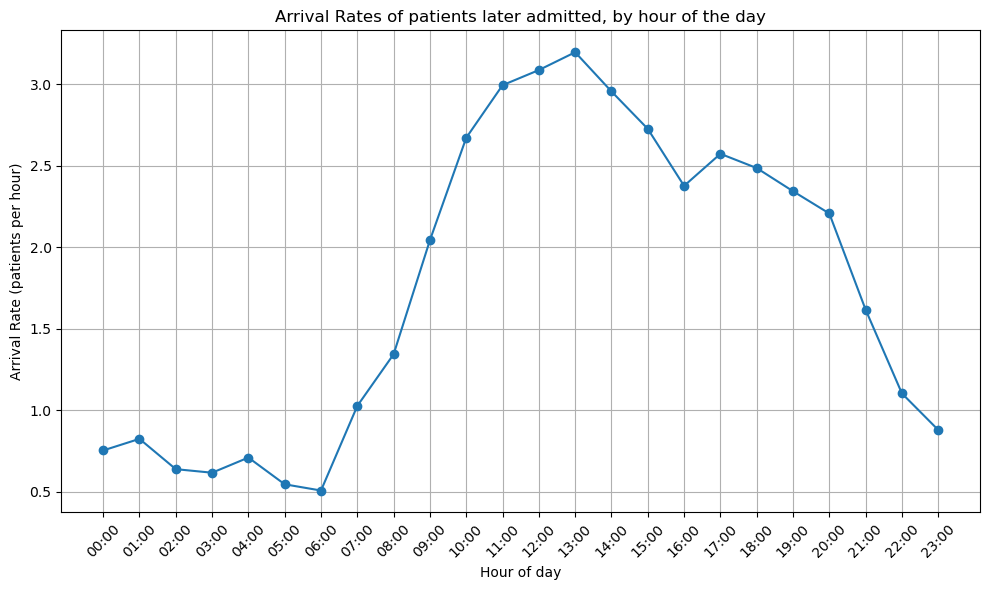

In [16]:
import matplotlib.pyplot as plt
import datetime

# Extract keys and values
hours = list(dict_.keys())
arrival_rates = list(dict_.values())

# Convert datetime.time objects to strings for better readability on the plot
hour_labels = [hour.strftime('%H:%M') for hour in hours]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, arrival_rates, marker='o')
plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Arrival Rate (patients per hour)')
plt.title('Arrival Rates of patients later admitted, by hour of the day')
plt.grid(True)
plt.tight_layout()
plt.show()

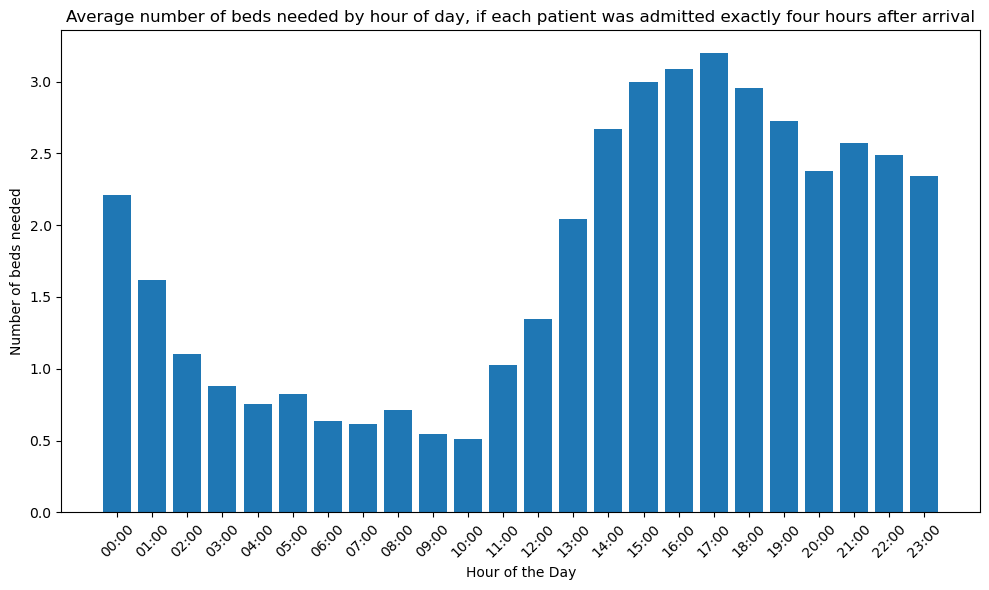

In [18]:
## Lag by four hours

from collections import OrderedDict

# Assuming 'dict' is already defined

# Lag the arrival times by 4 hours
lagged_dict = OrderedDict()
for time, rate in dict_.items():
    lagged_time = (datetime.datetime.combine(datetime.date.today(), time) + datetime.timedelta(hours=4)).time()
    lagged_dict[lagged_time] = rate

# Sort the dictionary by the new lagged time
sorted_lagged_dict = OrderedDict(sorted(lagged_dict.items()))

# Extract keys and values from the sorted dictionary
hours = list(sorted_lagged_dict.keys())
arrival_rates = list(sorted_lagged_dict.values())

# Convert datetime.time objects to strings for better readability on the plot
hour_labels = [hour.strftime('%H:%M') for hour in hours]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(hour_labels, arrival_rates)
plt.xticks(rotation=45)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of beds needed')
plt.title('Average number of beds needed by hour of day, if each patient was admitted exactly four hours after arrival')
# plt.grid(True)
plt.tight_layout()
plt.show()

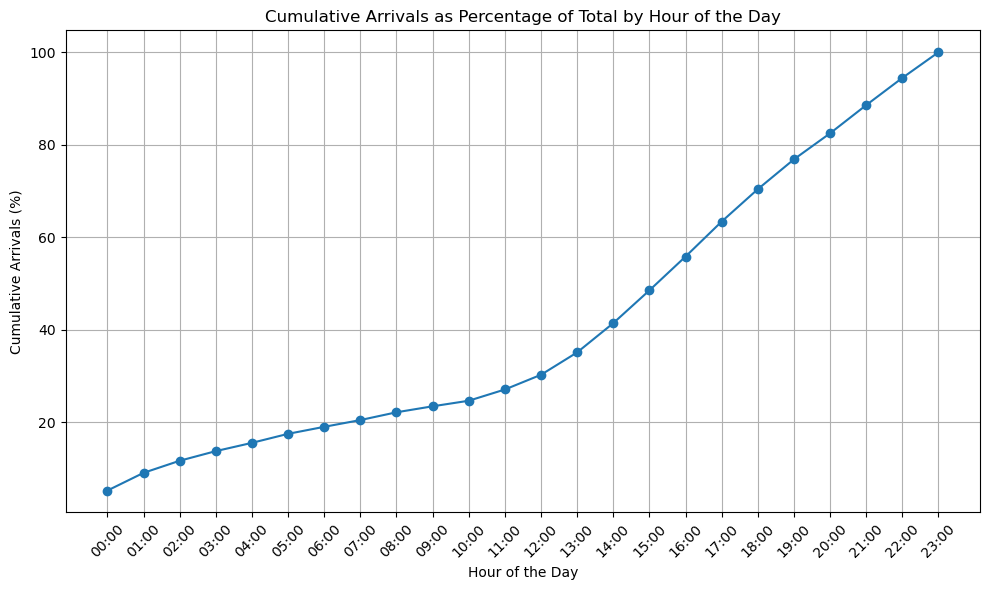

In [20]:
# Cumulative arrival rates
import numpy as np

# Calculate cumulative arrivals
total_arrivals = np.sum(arrival_rates)
cumulative_arrivals_percentage = (np.cumsum(arrival_rates) / total_arrivals) * 100


# Plot the cumulative data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, cumulative_arrivals_percentage, marker='o')
plt.xticks(rotation=45)
plt.xlabel('Hour of the Day')
plt.ylabel('Cumulative Arrivals (%)')
plt.title('Cumulative Arrivals as Percentage of Total by Hour of the Day')
plt.grid(True)
plt.tight_layout()
plt.show()

## For each hour after arrival, calculate the probability of being admitted in that hour if ED is performing according to targets

In [24]:
max_hours_since_arrival = 12
hours_since_arrival = np.arange(max_hours_since_arrival + 1)
print(hours_since_arrival)

from predict.emergency_demand.admission_in_prediction_window_using_aspirational_curve import get_y_from_aspirational_curve
prob_admission_by_this_hour = []
for i in range(len(hours_since_arrival)):
    prob = get_y_from_aspirational_curve(hours_since_arrival[i], x1, y1, x2, y2)
    prob_admission_by_this_hour.append(prob)
prob_admission_by_this_hour = np.array(prob_admission_by_this_hour)
prob_admission_by_this_hour

prob_admission_within_this_hour = np.diff(prob_admission_by_this_hour)
prob_admission_within_this_hour

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


array([0.01952592, 0.05765206, 0.170223  , 0.50259902, 0.07868125,
       0.05288651, 0.03554827, 0.02389418, 0.01606074, 0.01079541,
       0.00725626, 0.00487738])

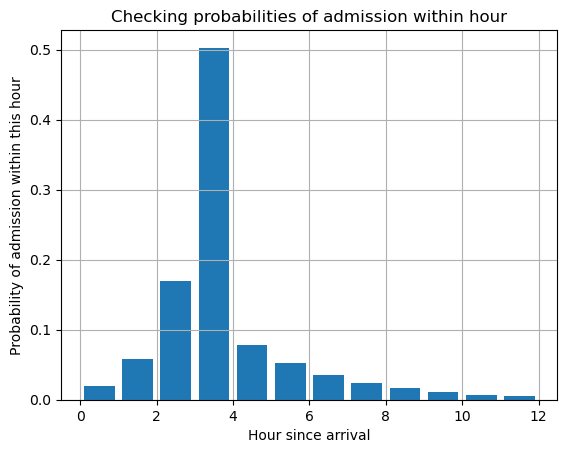

In [25]:
# plot these to check they are what we'd expect
plt.bar(np.arange(len(prob_admission_within_this_hour)) + 0.5, prob_admission_within_this_hour) # shifting bars to the left to portray the probability of admission within the hour
plt.xlabel('Hour since arrival')
plt.ylabel('Probability of admission within this hour')
plt.title('Checking probabilities of admission within hour')
plt.grid()
plt.show()

## True demand by hour

In [46]:
from predict.emergency_demand.time_varying_arrival_rates import calculate_rates
poisson_means_dict = calculate_rates(train_yta, time_interval = 60)
poisson_means = np.array(list(poisson_means_dict.values()))

Calculating time-varying arrival rates for data provided, which spans 183 days


In [47]:
# poisson mean at hour zero
poisson_means

array([0.75409836, 0.82513661, 0.63934426, 0.61748634, 0.71038251,
       0.54644809, 0.50819672, 1.0273224 , 1.3442623 , 2.04371585,
       2.67213115, 2.99453552, 3.08743169, 3.19672131, 2.95628415,
       2.72677596, 2.37704918, 2.57377049, 2.4863388 , 2.3442623 ,
       2.20765027, 1.61748634, 1.10382514, 0.87978142])

At hour zero, we have 0.75 arrivals on average, with a probability of this of being admitted within the hour

In [49]:
# Probability of admission in first hour
prob_admission_within_this_hour[0]

0.01952591723737189

We can multiply these to get a average number who will be admitted over the hour

In [51]:
# Average number of patients arriving between 0 and 1 hours, admitted between 0 and 1 if ED hitting targets
poisson_means[0] * prob_admission_within_this_hour[0]

0.014724462179001752

In [52]:
# Average number of patients arriving between 0 and 1 hours, admitted between 3 and 4 hours, if ED hitting targets
# Probability of admission in fourth hour
poisson_means[0] * prob_admission_within_this_hour[3]

0.379009097874089

This code sets up a 3D array called poisson_means_all with dimensions (max_hours_since_arrival, 24, where:

* The first dimension represents the hour since arrival (0 to 11).
* The second dimension holds the Poisson means for arrival rates within each hour after arrival, weighted by the probability of admission within that hour. This has length 24 because there are 24 hours in the day
  
Access the Poisson mean for any specific hour of the day, and hour after arrival using poisson_means_all[hour, i].

In [70]:
# Create an empty array to hold a Poisson distribution for each hour of the day, up to an arbitrary maximum number of arrivals in that hour
from scipy.stats import poisson
max_hours_since_arrival = 10
# Initialize a 3D array to hold all distributions across all hours
poisson_means_all = np.zeros((max_hours_since_arrival, len(poisson_means)))



In [71]:
for hour_of_day in range(0,24):
    arrival_rate = poisson_means[hour_of_day]
    for elapsed_hour_since_arrival in range(0, max_hours_since_arrival):
        weighted_arrival_rate = arrival_rate*prob_admission_within_this_hour[elapsed_hour_since_arrival]
        poisson_means_all[elapsed_hour_since_arrival][hour_of_day] = weighted_arrival_rate



In [64]:
# this holds the weighted arrival rates for patients admitted within the first hour of arrival, for each hour of the day
poisson_means_all[0]

array([0.01472446, 0.01611155, 0.01248378, 0.01205699, 0.01387087,
       0.0106699 , 0.00992301, 0.02005941, 0.02624795, 0.03990543,
       0.05217581, 0.05847105, 0.06028494, 0.06241892, 0.05772416,
       0.0532428 , 0.04641407, 0.05025523, 0.04854805, 0.04577387,
       0.0431064 , 0.0315829 , 0.0215532 , 0.01717854])

In [65]:
# this holds the weighted arrival rates for patients admitted within the fourth hour of arrival, for each hour of the day
poisson_means_all[3]

array([0.3790091 , 0.41471285, 0.3213338 , 0.31034803, 0.35703756,
       0.27464427, 0.25541917, 0.51633123, 0.67562491, 1.02716958,
       1.3430105 , 1.50505062, 1.55174015, 1.606669  , 1.48582552,
       1.37047493, 1.19470259, 1.29357453, 1.24963145, 1.17822393,
       1.10956287, 0.81294705, 0.55478143, 0.44217728])

Now let's add a third dimension

In [82]:
# Initialize a 3D array to hold all summed poisson means across all hours
poisson_means_sum = np.zeros(len(poisson_means))

for hour_of_day in range(0,24):
    sum_of_means = 0
    for elapsed_hour_since_arrival in range(0, max_hours_since_arrival):
        sum_of_means +=  poisson_means_all[elapsed_hour_since_arrival][hour_of_day]
    poisson_means_sum[hour_of_day] = sum_of_means


In [83]:
poisson_means_sum

array([0.72986644, 0.79862197, 0.6187998 , 0.59764426, 0.68755534,
       0.52888872, 0.49186651, 0.9943108 , 1.30106626, 1.97804382,
       2.58626585, 2.8983102 , 2.98822128, 3.09399902, 2.86128799,
       2.63915472, 2.30066594, 2.49106588, 2.40644369, 2.26893262,
       2.13671044, 1.56551062, 1.06835522, 0.85151084])

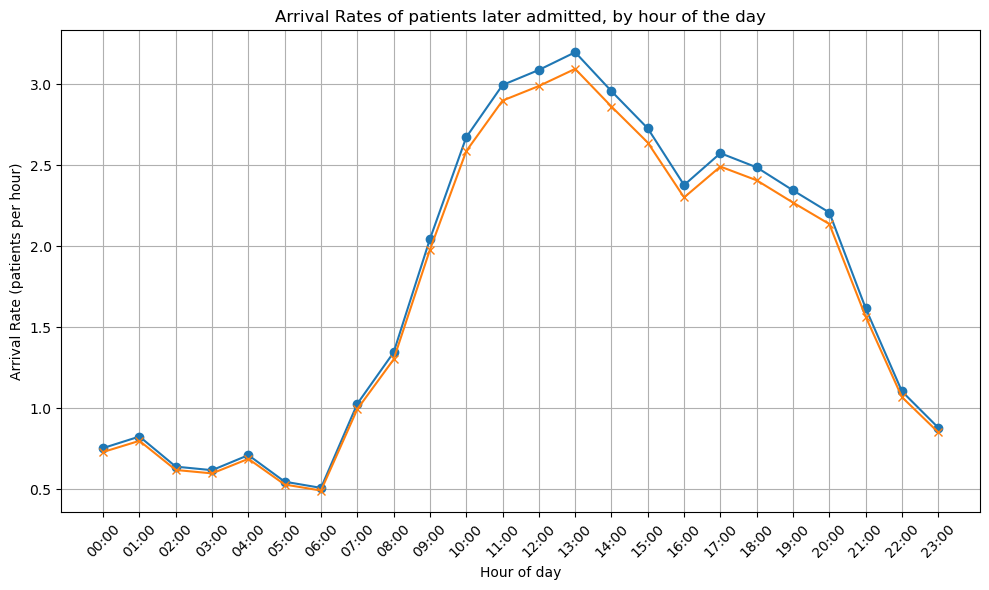

In [89]:
# Plot Poisson Means allowing for true ED performance

hours = list(dict_.keys())
arrival_rates = list(dict_.values())
arrival_rates_spread = poisson_means_sum

# Convert datetime.time objects to strings for better readability on the plot
hour_labels = [hour.strftime('%H:%M') for hour in hours]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, arrival_rates, marker='o')
plt.plot(hour_labels, arrival_rates_spread, marker='x')

plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Arrival Rate (patients per hour)')
plt.title('Arrival Rates of patients later admitted, by hour of the day')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# # Generate the Poisson distributions for each hour
# for i, mean in enumerate(poisson_means.values()):
#     poisson_distributions[i] = poisson.pmf(x, mean)

In [ ]:
# Extract keys and values from the sorted dictionary
hours = list(beds_dict_for_day.keys())

# Convert datetime.time objects to strings for better readability on the plot
hour_labels = [str(hour) + ':00' for hour in hours]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(hour_labels, beds_data)
plt.xticks(rotation=45)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of beds needed')
plt.title(str(cdf_cut_point*100 )+ '% probability of needing at least this number of beds this hour, if ED was performing according to targets')
# plt.grid(True)
plt.tight_layout()
plt.show()